In [1]:
# Define colors
Pitt.Blue<- "#003594"
Pitt.Gold<-"#FFB81C"
Pitt.DGray <- "#75787B"
Pitt.Gray <- "#97999B"
Pitt.LGray <- "#C8C9C7"
# ggplot preferences
library("ggplot2")
library("repr")
options(repr.plot.width=10, repr.plot.height=10/1.68)
Pitt.Theme<-theme( panel.background = element_rect(fill = "white", linewidth = 0.5, linetype = "solid"),
  panel.grid.major = element_line(linewidth = 0.5, linetype = 'solid', colour =Pitt.Gray), 
  panel.grid.minor = element_line(linewidth = 0.25, linetype = 'solid', colour = "white")
  )
base<- ggplot() +aes()+ Pitt.Theme

# Maximum Likelihood

In the last class we examined two types of model that were relatively agnostic with respect to how the error term was distributed (conditionally mean zero and homoskedastic) but where the non-linearity we introduced into the model meant that we had to solve for the optimal solutions using a numerical approach.

We're now going to think about a more-structured approach, where we will assume that we know how the randomness in our data is generated. We will then use this structure to generate a **likelihood function** for the data, in terms of the underlying parameters.

## Likelihood Modeling

In these models we assume a parameterized model for the data generating process. That is we will assume that each data outcome $y_i$ has a known probability distribution, conditional on:  
* any observables $\mathbf{x}_i$
* the parameters of the model $\boldsymbol{\theta}$

That is the observation $y_i$ has a probability distribution represented by some function $f_Y(y_i;\mathbf{x}_i,\boldsymbol{\theta} )$

### Example
Suppose that we assume that similar to classical linear regression, that the conditional outcome $Y_i|\mathbf{x}_i$ is normally distributed with: 
* mean of $\mathbf{x_i}\boldsymbol{\beta}$ 
* variance of $\sigma^2$.

In which case the density of $Y_i|\mathbf{x}_i$ is given by:
 $$f_Y(y_i)=\phi\left(\frac{y_i-\mathbf{x_i}\boldsymbol{\beta}}{\sigma}\right)$$

If we had three independent observations, the joint probability for drawing three values of $y$ from this normal distribution is given by:
$$\text{Density}(y_1,y_2,y_3)=\phi\left(\frac{y_1-\mathbf{x_1}\boldsymbol{\beta}}{\sigma}\right)\cdot \phi\left(\frac{y_2-\mathbf{x_2}\boldsymbol{\beta}}{\sigma}\right)\cdot \phi\left(\frac{y_3-\mathbf{x_3}\boldsymbol{\beta}}{\sigma}\right) $$

For right now, lets make this model even simpler, and assume that the $\mathbf{x_i}\boldsymbol{\beta}$ term is really simple, a constant $\beta_0$, and that we know that the variance of the error is 1.

If we knew the parameter $\beta_0$, then the density on any three values for $\mathbf{y}=(y_1,y_2,y_3)$ simplifies to:
$$\text{Density}(y_1,y_2,y_3)=\phi\left(y_1-\beta_0\right)\cdot \phi\left(y_2-\beta_0\right)\cdot \phi\left(y_3-\beta_0\right)  $$

So, this is the probability for any realization of the data, from an ex ante persepective. However, as data analysts, we don't see the true generation process, we only see the data: $$\mathbf{y}=(y_1,y_2,y_3).$$

If we knew the parameter values, we could therefore calculate how likely this sequence of data observations were:
$$ L(\beta_0,\sigma ; \mathbf{y}) =\phi\left(y_1-\beta_0\right)\cdot \phi\left(y_2-\beta_0\right)\cdot \phi\left(y_3-\beta_0\right)$$

The idea behind maximum likelihood is that can vary our guess on the parameter $\beta_0$ to try to get a sense for how likely the data would be if that were the true parameter.

For example, consider realized data on the outcome given by $\mathbf{y}=(1,-1,3)$

In [2]:
dnorm(1)

[1] 0.2419707

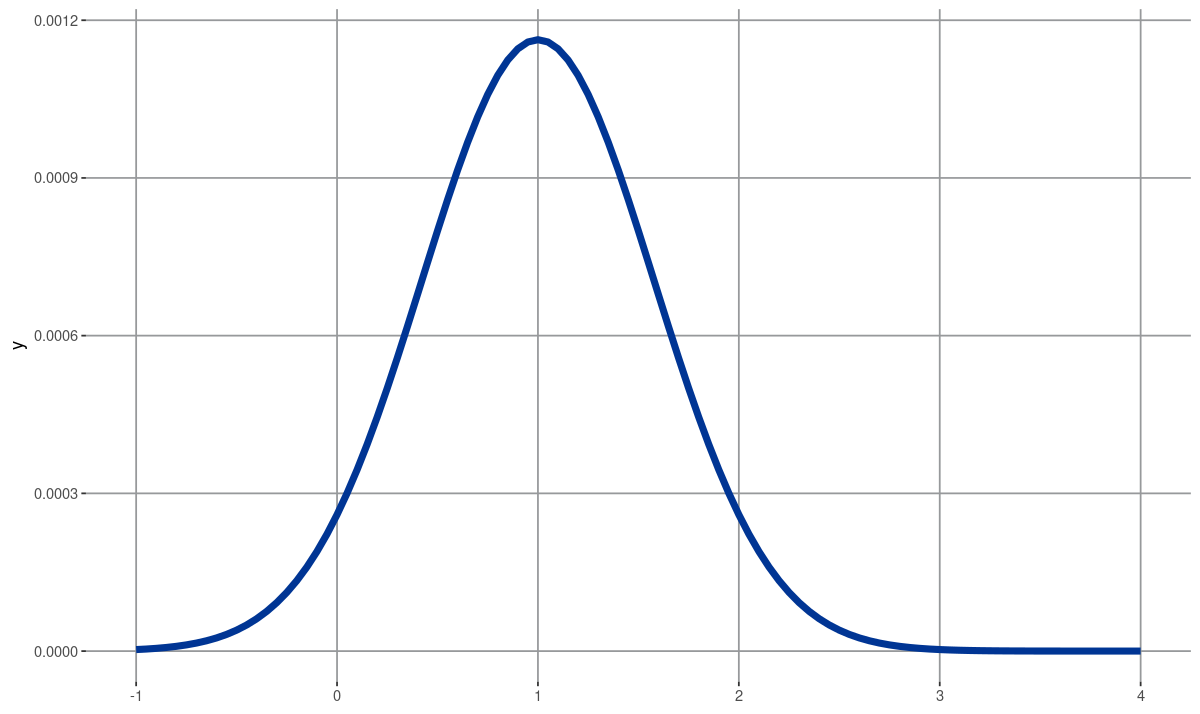

In [3]:
example.likelihood<-function(beta0) dnorm(1-beta0)*dnorm(-1-beta0)*dnorm(3-beta0)
base+geom_function(fun=example.likelihood, color=Pitt.Blue,linewidth=2)+ xlim(-1,4)

The likelihood is maximized at a value of $\hat{\beta}_0=1$, which we can check with the `optimize()` function:

In [4]:
likelihood.opt<-optimize(example.likelihood,interval=c(0,2),maximum=TRUE) 
likelihood.opt  

$maximum
[1] 1

$objective
[1] 0.001162927

## Log-likelihoods
When we're dealing with lots of *independent* draws, the probability for the joint data will be the **product** of each of the marginal distributions. 

That is:
$$L(\theta;y)=\prod_{i=1}^n \Pr\left\{ y_i;\theta\right\}=\Pr\left\{ y_1;\theta\right\}\cdot\Pr\left\{ y_2;\theta\right\}\cdots\Pr\left\{ y_{n-1};\theta\right\}\cdot \Pr\left\{ y_n;\theta\right\}$$

When multiplying lots of small numbers together, the resulting product can get very small, and small-errors in how the computer represents numbers can lead us to make mistakes. Moreover, this will be annoying to take derivatives over.

To remedy this we will use a frequent "trick" in optimization.

### Transforming the objective function
If a value $x$ maximizes/minimizes a function $f(x)$, then it will also maximize the transformation $g\bigl(f\left(x\right)\bigr)$ so long as $g(\cdot)$ is a strictly increasing function

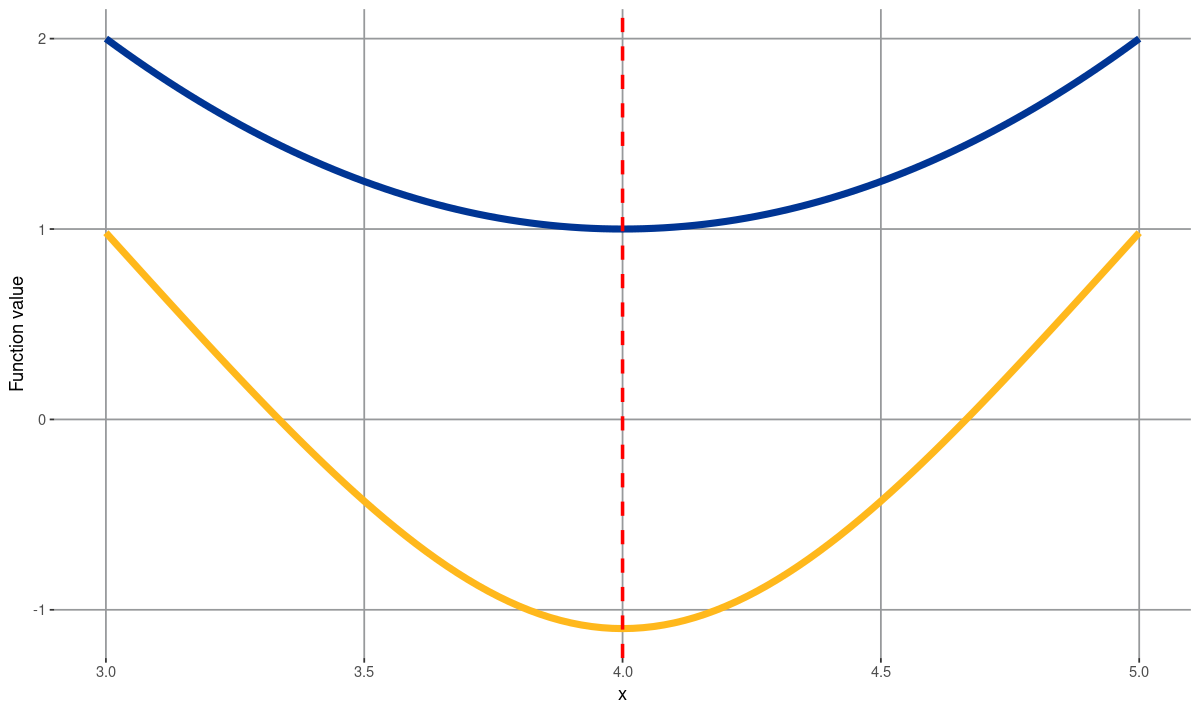

In [5]:
example.f<-function(x) (x-4)**2+1
example.g<-function(x) log(example.f(x)^3/3)
base+geom_function(fun=example.f, color=Pitt.Blue,linewidth=2)+geom_function(fun=example.g, color=Pitt.Gold,linewidth=2)+ xlim(3,5)+
geom_vline(xintercept = 4,linewidth=1,color="red",linetype = "dashed")+xlab("x")+ylab("Function value")

The *value* of the function $g\bigl(f(x)\bigr)$ is different almost everywhere from $f(x)$... 

...but, importantly the underlying point that minimizes/maximizes the function does not change.

### Using this...

We will make the *product* of the probabilities in the Likelihood expressible as a sum through a $\log(\cdot)$ transformation. We will therefore look to maximize the **log-likelihood**:
$$l(\theta;y)=\log(L(\theta;y))$$

Here we use two ideas:
* The $\log$ function is strictly increasing on $(0,\infty)$
* The likelihood must be positive for any feasible parameters, so the product must also be positive
    - Note that if any of the probablities are zero, we'll get an error
    - However, the interpretation will be that the data is *not* possible at this parameterization 

We will therefore try to maximize the log-likelihood:
$$l(\theta;y)=\log\left(\prod_{i=1}^n \Pr\left\{ y_i;\theta\right\}\right)=\sum_{i=1}^n \log(\Pr\left\{ y_i;\theta\right\})$$

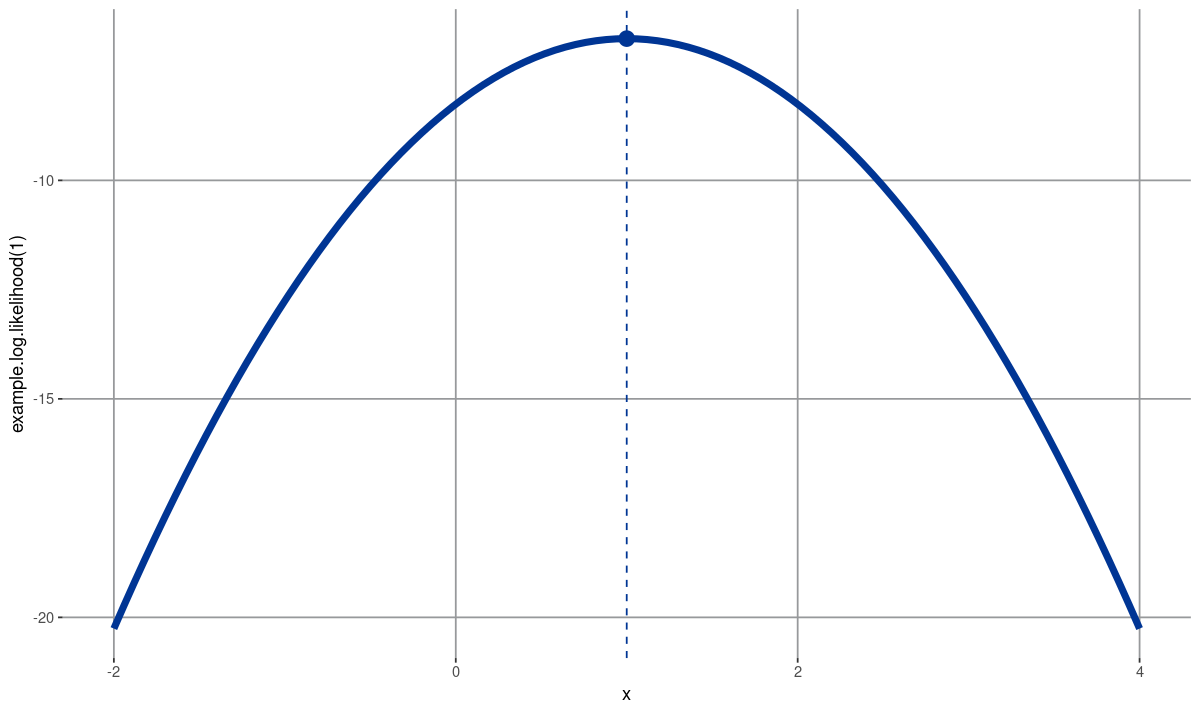

In [6]:
example.log.likelihood<-function(beta0) log(dnorm(1-beta0))+log(dnorm(-1-beta0))+log(dnorm(3-beta0))
base+geom_function(fun=example.log.likelihood, color=Pitt.Blue,linewidth=2)+ xlim(-2,4)+
geom_point(aes(x=1,y=example.log.likelihood(1)),size=4,color=Pitt.Blue)+geom_vline(xintercept=1,color=Pitt.Blue,linetype="dashed")

Which has the same optimizing value of $\beta_0$, but a different value at the objective:

In [7]:
log.opt<-optimize(example.log.likelihood,interval=c(0,2),maximum=TRUE)
log.opt

$maximum
[1] 1

$objective
[1] -6.756816

But we can just reverse the original transformation to get the likelihood!

In [8]:
exp(log.opt$objective) # exp(LogLilihood Max)
likelihood.opt$objective # Likelihood Max

[1] 0.001162927

[1] 0.001162927

Here, we could have figured out the optimal value by just taking an analytical derivative for the first-order condition:
$$\frac{\partial l(\beta_0)}{\partial \beta_0}= \sum_{i=1}^n \frac{\partial}{\partial\beta_0} \log\left(\phi\left( y_i-\beta_0\right)\right)=\sum_{i=1}^n \frac{-\phi^\prime(y_i-\beta_0)}{\phi(y_i-\beta_0)}$$

So we just need to solve for the derivative of:
$$ \phi(z)=\frac{1}{\sqrt{2\pi}}\exp\left(-\tfrac{1}{2}z^2\right)$$

You can check this yourselves, but I get:
$$\phi^\prime(z)=\frac{\partial\phi(z)}{\partial z}=\frac{1}{\sqrt{2\pi}}\exp\left(-\tfrac{1}{2}z^2\right)\cdot (-z)=-\phi(z)\cdot z$$


But that means that:
$$\frac{\partial l(\beta_0)}{\partial \beta_0}= \sum_{i=1}^n \frac{-\phi^\prime(y_i-\beta_0)}{\phi(y_i-\beta_0)}=
\sum_{i=1}^n \frac{\phi(y_i-\beta_0)(y_i-\beta)}{\phi(y_i-\beta_0)}$$

So our first-order condition simplifies to:
$$ \frac{\partial l(\beta_0)}{\partial \beta_0}=\sum_{i=1}^n(y_i-\beta_0)=0$$

So the maximium likelihood value for $\beta_0$ is where this slope is zero, but this is just:
$$\hat{\beta}_0=\frac{1}{n}\sum_{i=1}^n y_i =\bar{y}$$
A fairly sensible maximizer when we're looking for the mean!

If we didn't know the standard-deviation parameter $\sigma$, the log likelihood function would have been:
$$l(\beta_0,\sigma ;y)=\log\left(\phi\left( \tfrac{y_i-\beta_0}{\sigma}\right)\right)$$

And we would have had to solve for two first order conditions
1.  $\frac{\partial l(\beta_0)}{\partial \beta_0}=\sum_{i=1}^n\frac{y_i-\beta_0}{\sigma}=0$
2.  $\frac{\partial l(\beta_0)}{\partial \sigma}=\sum_{i=1}^n\frac{(y_i-\beta_0)^2-\sigma^2}{\sigma^3}=0$

This leads to two solutions for the parameters:
1. $\hat{\beta}=\tfrac{1}{n}\sum_{i=1}^n y_i=\bar{y}$
2. $\hat{\sigma}=\sqrt{\tfrac{1}{n}\sum_{i=1}^n (y_i-\bar{y})^2}$

**Question:** How does this differ from the formula you would get from OLS?

**Question:** Are either of these estimators biased?

**Question:** Are either of these estimators consistent?

### Numerically we get the same thing:
Make some data where $y\sim \mathcal{N}(3,4)$

In [9]:
y<-rnorm(1000,mean=3,sd=2) # True mean of 3, and sd of 2.
mean(y)
sd(y)

[1] 2.896281

[1] 2.039145

Define a function that calculates the log-likelihood over $y$:

In [10]:
example.log.likelihood.n <- function(theta)  sum( sapply( y, dnorm, mean=theta[1], sd=theta[2] ,log=TRUE) )
# this function applies dnorm() to the yList, applying the mean=theta[1] and sd=theta[2], and taking logs

We find the maximum value of this function using the `optim()` function

In [11]:
# Guess mean 0 sd=1 to begin with... 
mle.est<-optim( par= c(0,1) , fn=example.log.likelihood.n, control=list(fnscale=-1))
mle.est 
mle.est$par
mle.est$value

$par
[1] 2.896919 2.038211

$value
[1] -2130.969

$counts
function gradient 
      73       NA 

$convergence
[1] 0

$message
NULL

[1] 2.896919 2.038211

[1] -2130.969

Let's look at a slice of the likelihood across $\beta_0$ while we hold constant the estimate $\hat{\sigma}$ (this is called the **concentrated likelihood**)

In [12]:
betaInVals<-seq(2,4,by=0.05)
beta.slice<- function(beta0) sum( sapply( y, dnorm, mean=beta0, sd=mle.est$par[2] ,log=TRUE))
beta.slice.df<-data.frame(b=betaInVals,l=sapply(betaInVals,beta.slice))

And do the same thing for $\sigma$

In [13]:
sigmaInVals<-seq(1,3,by=0.05)
sigma.slice<- function(sigma) sum( sapply( y, dnorm, mean=mle.est$par[2], sd=sigma ,log=TRUE))
sigma.slice.df<-data.frame(s=sigmaInVals,l=sapply(sigmaInVals,sigma.slice))

Plotting the concentrated likelihood function over $\beta_0$ (this is the log-likelihood fixing $\sigma=\hat{\sigma}$)

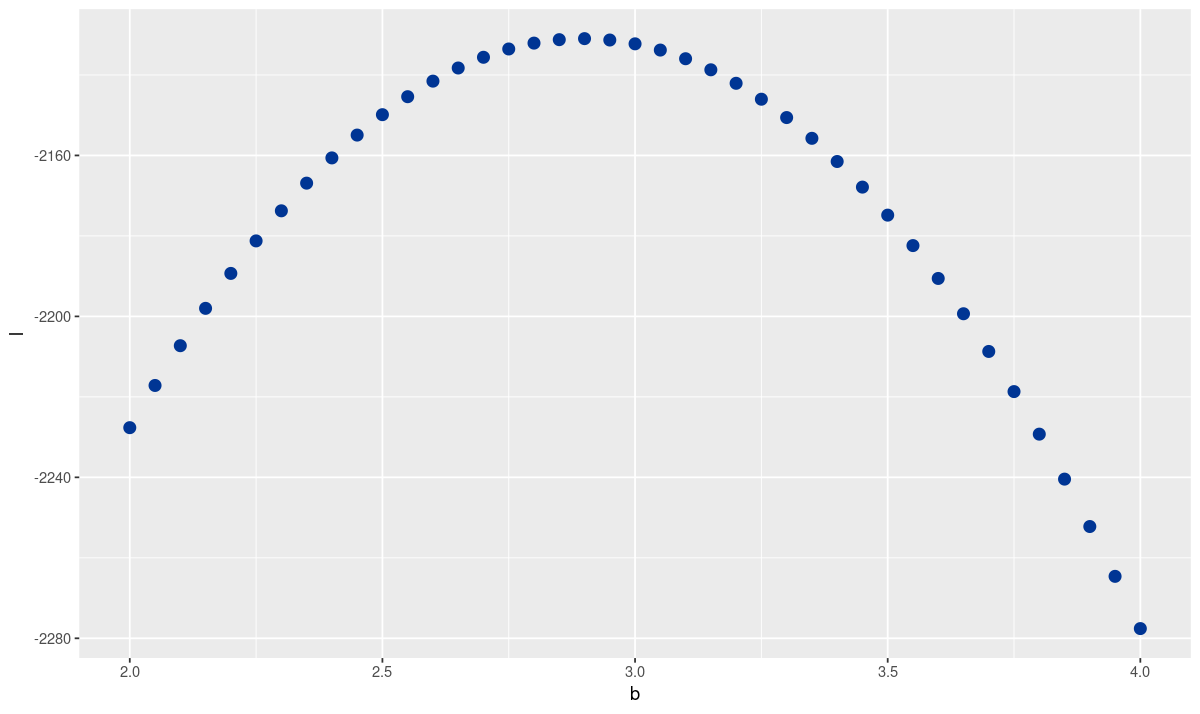

In [14]:
ggplot(beta.slice.df,aes(x=b,y=l)) + geom_point(color=Pitt.Blue,size=3) 

And plotting the concentrated likelihood function by $\sigma$ (the log-likelihood fixing $\beta_0=\hat{\beta}_0$)

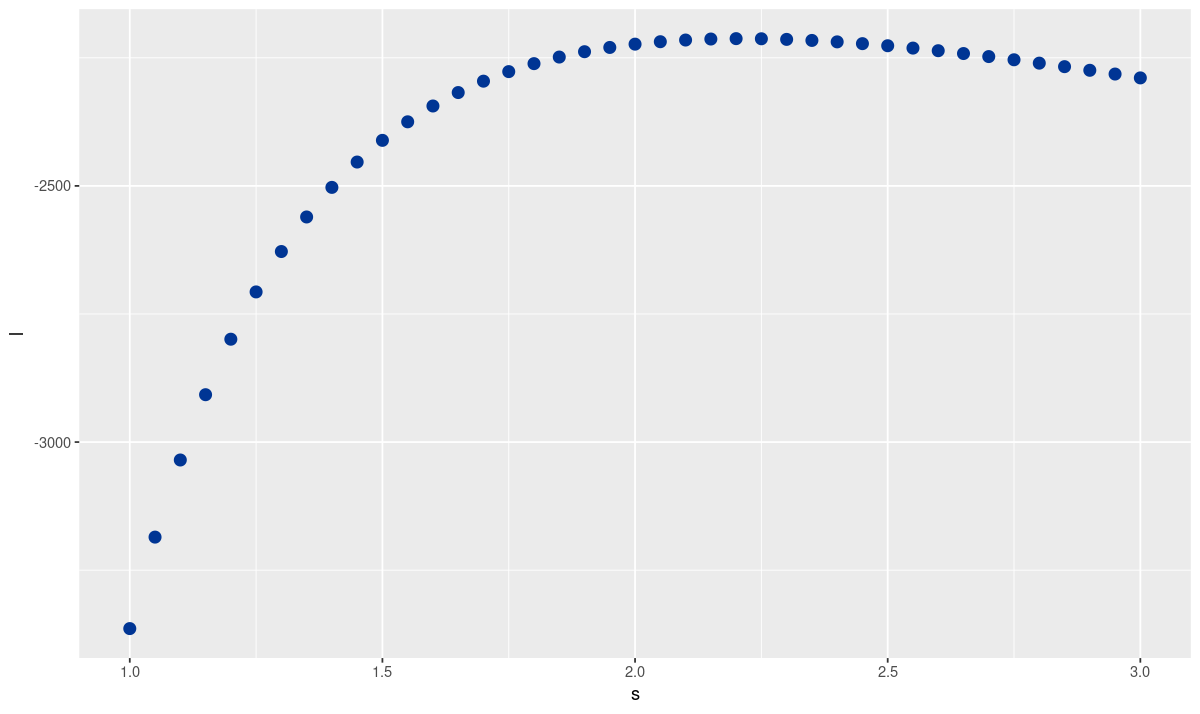

In [15]:
 ggplot(sigma.slice.df,aes(x=s,y=l)) + geom_point(color=Pitt.Blue,size=3) 

## Poisson Example
So let's think through the maximum likelihood equations for a Poisson model where each data point is a random count $K_i$ with probability given by:
$$ \text{Pr}\left(K_i=k\right)=\frac{\lambda^k e^{-\lambda}}{k!}$$

So suppose that we have a sample of iid draws $(k_1,k_2,\ldots,k_N)$... What is the max-likelihood estimator of $\lambda$?

## Multinomial Example

Here the random variable $Y_i$ can take on $K$ different values from $1$ to $K$. The entire dataset is summarized by the number of observations $n_k$ for each type realization $k$.

The probability of the data is therefore:
$$L(\mathbf{p})=\frac{n!}{n_1!\cdots n_k!} p_1^{n_1}\cdots p_K^{n_K}$$
where $p_k$ is a parameter indicating the probability of type $k$.

The log-liklihood is therefore:
$$l(\mathbf{p})=\sum_{k=1}^K n_k \cdot \log(p_k) $$
subject to $\sum_k p_k=1$

But here we need to constrain the parameters, which have to sum up to 1!
$$l(\mathbf{p})=\sum_{k=1}^{K-1} n_k \cdot \log(p_k) +(n-\sum_{k=1}^{K-1} n_k)\log(1-\sum_{k=1}^{K-1}  p_k)$$

So the first-order condition for $p_k$ is:
$$\frac{n_k}{p_k}-\lambda=0\Rightarrow n_k=\lambda p_k$$

So $\lambda=n$ from summing the $n$ equations and using the constraint, so the max likelihood solution is:
$$\hat{p}_k=\frac{n_k}{n}$$

## Uniform Example
How about if we have a series of uniform draws on the interval $[0,\theta]$. So the density on a particular value $u$ is given by:
$$f(u)=\begin{cases}\frac{1}{\theta} & \text{if } 0\leq u \leq \theta,  \\ 0 & \text{otherwise.}\end{cases}$$

**Question:** Suppose that we have a sample $(u_1,u_2,\ldots,u_N)$, what is the max likelihood estimator of $\theta$?

## Adding in observables
As we go forward, we'll add conditioning variables into the parameterizations, to try to understand how the estimated probabilities/means/variances shift with other features of the data.

In particular, in many instance we will set up a similar model to the standard linear models from before, where we will model the outcome $y_i$ through a linear combination of the observables $\mathbf{x}_i \boldsymbol{\beta}$. The difference will be that this mean will then enter in a non-linear way into the estimation equations.

For many examples, this will fit into a wider estimation methodology called *generalized linear models* which we will come back to later. For now though, let's proceed by adding some very simple conditioning variables.

Let's start by adding in observable groups, simple factor variables indicating group membership:

### Poisson with observable groups
Suppose we instead wanted to understand differences across a number of observable groups using count data. That is for each observation, we see the data $(k_i,g_i)$ where $k_i$ is the count we want to explain, and $g_i$ is a factor variable indicating the group that $i$ belongs to (1 to $G$).

We begin to estimate a model where each group's mean is given by $\lambda_g=\lambda_0+ \delta_g$, an average level across all of the groups $\lambda_0$ and a deviation by group $\delta_g$

However, when we try to maximize this we immediately encounter a problem when we solve for the optimal solutions to :
$$ l(\lambda_0,\delta_1,\cdots, \delta_G)= \sum^N_{i=1} \left( k_i \log(\lambda_0+\delta_{g_i})-(\lambda_0+\delta_{g_i})-\log(k_i!)\right)$$

The FOC for $\lambda_0$ is:
$$\text{Eq. }\lambda :\sum_{i=1}^N \frac{k_i}{\lambda_0+\delta_{g_i}}=N$$
While the FOC for a generic group deviation $\delta_g$ is:
$$ \text{Eq. }g : \sum_{i:g_i=g} \frac{k_i}{\lambda_0+\delta_{g_i}} =N_g = (\text{\# in group }g)$$

But if we sum over the $G$ group first order conditions $\sum_{g=1}^G (\text{Eq }g)$ we get:
 $$   \sum_g\sum_{i:g_i=g}\frac{k_i}{\lambda_0+\delta_{g_i}}=\sum_g N_g$$
 
But this is exactly:
$$\lambda :\sum_{i=1}^N \frac{k_i}{\lambda_0+\delta_{g_i}}=N$$

As such, we know that we only have $G$ equations in $G+1$ unknowns... so we can't find a unique solution to maximize this function. 

The problem comes about because to identify a parameter vector $\theta$ it has to be the case that different parameters values lead to different distributions in the likelihoods.

* Here we didn't pin down the distribution, because if the parameter for each group is $\lambda+\delta_g$, we could subtract some amount from lambda, and add that amount to all of the groups.
* In this case, the problem is directly analogous to including too many controls in a linear model
    - We need to either normalize one of the groups to have a zero value for the deviation
    - Or we can enforce a constraint that $\sum_g \delta_g=0$ so that the parameters are deviations around the average

Non-identifiability problems are generally harder to track down in non-linear models, the numerical optimization routines we use to find solutions won't necessarily tell us that we have a problem on this margin

Instead, this will tend to creep up as a failure to converge in your likelihood estimations, where you will then have to diagnose how to resolve the multiplicity.

## Estimation Example
Our soccer scorelines model provides an example for a simple model where the parameters can be **estimated** from the outcomes

The model for your simulation specified that the number of goals scored by team $i$ when facing team $j$ is a Poisson variable with parameter $\lambda_{ij}=\exp(\alpha_i-\delta_j)$, where
* $\alpha_i$ is team $i$'s attacking parameter
* $\delta_j$ is team $j$'s defense parameter

I'm going to expand this by allowing for an average number of goals scored parameter $\mu$, and a home-stadium effect $\eta$.

That is the parameter for team $i$ is:
* $\lambda_{ij}=\exp(\mu+\eta+\alpha_i-\delta_j)$  if they are the home team
* $\lambda_{ij}=\exp(\mu+\alpha_i-\delta_j)$  if they are the away team

The probability of the team scoring $k$ goals is then given by:
$$\Pr\left\{k;\lambda_{ij}\right\}= \frac{\lambda_{ij}^k e^{-\lambda_{ij}}}{k!}$$

But so the log probability for $k$ goals simplifies to:
$$\log\left(Pr\left\{k;\lambda_{ij}\right\}\right)= k\cdot\log \lambda_{ij}-\lambda_{ij}-\log(k!)$$

Given our model specification of $\lambda_{ij}=\exp(\alpha_i-\delta_j)$ this reduces even further to:
$$\log\left(Pr\left\{k;\lambda_{ij}\right\}\right)= \begin{cases}k\cdot(\mu+\eta +\alpha_i-\delta_j)-\exp(\mu+\eta+\alpha_i-\delta_j)-\log(k!) & \text{if $i$ is home team} \\ k\cdot(\mu +\alpha_i-\delta_j)-\exp(\mu+\alpha_i-\delta_j)-\log(k!) & \text{if $i$ is away team} \end{cases}$$

## Identification problems?

We've doubled up our identification problems from before:
* If we add and subtract from $\mu$, and put this into each of the $\alpha_i$ terms then we would have the same mean value
* But this is also true for the $\delta_j$ terms.
* Similarly, if we add any constant to all of the $\alpha$ *and* $\delta$ terms.  

Here our solution is to make sure that the sum of each team specific variation sums to zero, that is:
* $\sum_j \alpha_i=0$
* $\sum_j \delta_j=0$

As such each team specific term is a *deviation* around the average number of goals scored/conceded.


## Coding it up
I'm going to grab the scoreline data from this website:

In [16]:
data2024.25 <- read.csv('https://www.football-data.co.uk/mmz4281/2425/E0.csv')
data2023.24 <- read.csv('https://www.football-data.co.uk/mmz4281/2324/E0.csv')
data2022.23 <- read.csv('https://www.football-data.co.uk/mmz4281/2223/E0.csv')
data2021.22 <- read.csv('https://www.football-data.co.uk/mmz4281/2122/E0.csv')
data2020.21 <- read.csv('https://www.football-data.co.uk/mmz4281/2021/E0.csv')
#data2019.20 <- read.csv('https://www.football-data.co.uk/mmz4281/1920/E0.csv')
#data2018.19 <- read.csv('https://www.football-data.co.uk/mmz4281/1819/E0.csv')

In [17]:
allTeam<-sort(unique(c(unique(data2024.25$HomeTeam),unique(data2024.25$AwayTeam))))
#allTeam20.21<-unique(c(unique(data2020.21$HomeTeam),unique(data2020.21$AwayTeam)))
#allTeam19.20<-unique(c(unique(data2019.20$HomeTeam),unique(data2019.20$AwayTeam)))
#allTeam18.19<-unique(c(unique(data2018.19$HomeTeam),unique(data2018.19$AwayTeam)))

In [18]:
allTeam

[1] "Arsenal"        "Aston Villa"    "Bournemouth"    "Brentford"     
 [5] "Brighton"       "Chelsea"        "Crystal Palace" "Everton"       
 [9] "Fulham"         "Ipswich"        "Leicester"      "Liverpool"     
[13] "Man City"       "Man United"     "Newcastle"      "Nott'm Forest" 
[17] "Southampton"    "Tottenham"      "West Ham"       "Wolves"

Here I join the two data sets, but where I make sure only to bring in the data on teams from the current season:

In [19]:
sameTeamData23.24<-subset(data2023.24, 
                     is.element(HomeTeam,allTeam) & is.element(AwayTeam,allTeam), #only take teams in 2023-24 season data
                     c("HomeTeam","AwayTeam","FTHG","FTAG","Date"))
sameTeamData22.23<-subset(data2022.23, 
                     is.element(HomeTeam,allTeam) & is.element(AwayTeam,allTeam), #only take teams in 2022-23 season data
                     c("HomeTeam","AwayTeam","FTHG","FTAG","Date"))
sameTeamData21.22<-subset(data2021.22, 
                     is.element(HomeTeam,allTeam) & is.element(AwayTeam,allTeam), #only take teams in 2021-22 season data
                     c("HomeTeam","AwayTeam","FTHG","FTAG","Date"))

if we wanted previous seasons could run
```
sameTeamData20.21<-subset(data2020.21, 
                     is.element(HomeTeam,allTeam) & is.element(AwayTeam,allTeam), #only take teams in 2020-21 season data
                     c("HomeTeam","AwayTeam","FTHG","FTAG"))
sameTeamData19.20<-subset(data2019.20, 
                     is.element(HomeTeam,allTeam) & is.element(AwayTeam,allTeam), #only take teams in 2020-21 season data
                     c("HomeTeam","AwayTeam","FTHG","FTAG")) #only take these fields
sameTeamData18.19<-subset(data2018.19, 
                     is.element(HomeTeam,allTeam) & is.element(AwayTeam,allTeam), #only take teams in 2020-21 season data
                     c("HomeTeam","AwayTeam","FTHG","FTAG"))
```

Join the data

In [20]:
seasonsJoined<- rbind(data2024.25[c("HomeTeam","AwayTeam","FTHG","FTAG","Date")],sameTeamData23.24)#,#sameTeamData22.23)#,sameTeamData21.22)#sameTeamData20.21) #join the data frames on these common columns
seasonsJoined$Date<-as.Date(seasonsJoined$Date,format="%d/%m/%Y")
seasonsJoined <- seasonsJoined[order(seasonsJoined$Date,decreasing = TRUE),]

In [21]:
head(seasonsJoined)

,HomeTeam,AwayTeam,FTHG,FTAG,Date
,<chr>,<chr>,<int>,<int>,<date>
293,Bournemouth,Ipswich,1,2,2025-04-02
294,Brighton,Aston Villa,0,3,2025-04-02
295,Man City,Leicester,2,0,2025-04-02
296,Newcastle,Brentford,2,1,2025-04-02
297,Southampton,Crystal Palace,1,1,2025-04-02
298,Liverpool,Everton,1,0,2025-04-02


Initialize the parameters:

In [22]:
paramTable<-data.frame(number=1:20)
paramTable["alpha"]=0
paramTable["delta"]=0
rownames(paramTable)<-allTeam
head(paramTable)

,number,alpha,delta
,<int>,<dbl>,<dbl>
Arsenal,1,0,0
Aston Villa,2,0,0
Bournemouth,3,0,0
Brentford,4,0,0
Brighton,5,0,0
Chelsea,6,0,0


Here I will assign each row in the dataset the team number from the paramTable:

In [23]:
seasonsJoined["HomeNo"]<- 1
seasonsJoined["AwayNo"]<- 1
for  (row in 1:nrow(seasonsJoined)) {
    seasonsJoined[row,"HomeNo"]<-  paramTable[ seasonsJoined[row,"HomeTeam"],"number"]
    seasonsJoined[row,"AwayNo"]<- paramTable[ seasonsJoined[row,"AwayTeam"],"number"]
    }
head(seasonsJoined)

,HomeTeam,AwayTeam,FTHG,FTAG,Date,HomeNo,AwayNo
,<chr>,<chr>,<int>,<int>,<date>,<dbl>,<dbl>
293,Bournemouth,Ipswich,1,2,2025-04-02,3,10
294,Brighton,Aston Villa,0,3,2025-04-02,5,2
295,Man City,Leicester,2,0,2025-04-02,13,11
296,Newcastle,Brentford,2,1,2025-04-02,15,4
297,Southampton,Crystal Palace,1,1,2025-04-02,17,7
298,Liverpool,Everton,1,0,2025-04-02,12,8


Use the numbered factors for estimation:

In [24]:
estimData<-seasonsJoined[c("HomeTeam","HomeNo","AwayTeam","AwayNo","FTHG","FTAG")]
save(estimData,file="soccer/soccerData.rda") 

In [25]:
estimData

,HomeTeam,HomeNo,AwayTeam,AwayNo,FTHG,FTAG
,<chr>,<dbl>,<chr>,<dbl>,<int>,<int>
293,Bournemouth,3,Ipswich,10,1,2
294,Brighton,5,Aston Villa,2,0,3
295,Man City,13,Leicester,11,2,0
296,Newcastle,15,Brentford,4,2,1
297,Southampton,17,Crystal Palace,7,1,1
298,Liverpool,12,Everton,8,1,0
290,Arsenal,1,Fulham,9,2,1
291,Wolves,20,West Ham,19,1,0
292,Nott'm Forest,16,Man United,14,1,0


Setting some initial value guesses for a mean and home paramter

In [26]:
theta0<-replicate(40, 0) # Make a vector of 40 zeros, for 19 teams *2 +2 additional parameters
theta0[39]<-log(mean(estimData$FTAG)) 
theta0[40]<-log(mean(estimData$FTHG))-theta0[39]

Guess the team parameters

In [27]:
for (i in 1:20){
theta0[2*(i-1)+1]=log(mean(append(subset(estimData,HomeNo==i)$FTHG,subset(estimData,AwayNo==i)$FTAG)))-(theta0[39]+theta0[40]/2)
theta0[2*(i-1)+2]=(theta0[39]+theta0[40]/2)-log(mean(append(subset(estimData,HomeNo==i)$FTAG,subset(estimData,AwayNo==i)$FTHG)))
}
theta0

[1]  0.239125851  0.644641689  0.068308119 -0.038455155 -0.068028325
 [6] -0.007683497 -0.024065201 -0.116164140 -0.045805188 -0.038455155
[11]  0.195794275  0.007804681 -0.121563566  0.074496055 -0.397781611
[16]  0.137824087 -0.102317398  0.045805188 -0.429530310 -0.312407035
[21] -0.611851866 -0.373964928  0.392095196  0.397781611  0.355990191
[26]  0.308169453 -0.137824087  0.013369912  0.169126028 -0.002890608
[31] -0.079327880  0.002787803 -0.739685238 -0.431952186  0.195794275
[36] -0.054715676 -0.174638060 -0.205509240 -0.125847896 -0.691265712

Create the Likelihood function

In [28]:
likelihood.function <- function(theta) {
    alpha<- replicate(20, 0) #initialize
    delta<- replicate(20, 0)
    for (i in 1:19) {
        alpha[i]<- theta[ 2*(i-1)+1 ]
        delta[i]<- theta[ 2*(i-1)+2 ]
        }
    alpha[20] <-  -1*sum( alpha[1:19] ) #sum to zero constraint
    delta[20] <-  -1* sum( delta[1:19] ) #sum to zero constraint
    lambdaH <- replicate(nrow(estimData), 0)
    lambdaA <- replicate(nrow(estimData), 0)
    prob <- replicate(nrow(estimData), 0)
    for (row in 1:nrow(estimData) ){
        H <- estimData$HomeNo[row]
        gH <- estimData$FTHG[row]
        A <- estimData$AwayNo[row]
        gA <- estimData$FTAG[row]
                 # mean param+ home + alpha_i- delta_j
        lambdaH <- theta[39]+theta[40]+alpha[H]-delta[A]
                  # mean param +    alpha_j -  delta_i
        lambdaA <- theta[39]  +     alpha[A]-delta[ H ]
        prob[row] <- gH*lambdaH - exp(lambdaH) - log(factorial(gH) ) + #Home Goal part
                    gA*lambdaA  -exp(lambdaA) - log(factorial(gA) ) #Away part
    }
    return(sum( prob ))
}
likelihood.function(theta0)

[1] -2332.213

Maximize the parameters

In [29]:
#out<-optim(theta0,likelihood.function,control=list(fnscale=-1),method="CG" )
#theta0<-out$par
out<-optim(theta0,likelihood.function,control= list(fnscale=-1), method="BFGS"  )

Let's rearrange things so we can see the model estimates:

In [30]:
theta.out<-out$par
alphaOut<- replicate(20, 0) #initialize
deltaOut<- replicate(20, 0)
for (i in 1:19) {
    alphaOut[i]<- theta.out[2*(i-1)+1]
    deltaOut[i]<- theta.out[2*(i-1)+2]
    }
alphaOut[20] <-  -1*sum( alphaOut[1:19] ) #sum to zero constraint
deltaOut[20] <-  -1* sum( deltaOut[1:19] )
names(alphaOut)<- allTeam
names(deltaOut)<- allTeam


Write things to a dataframe

In [31]:
outModel<-data.frame(alpha=alphaOut,delta=deltaOut)
outModel["XG"] <-exp( theta.out[39]+outModel$alpha)
outModel["XGA"] <-exp( theta.out[39]-outModel$delta )
outModel
save(outModel,theta.out,estimData,file="soccer/SoccerEst.rda")

,alpha,delta,XG,XGA
,<dbl>,<dbl>,<dbl>,<dbl>
Arsenal,0.287446035,0.651059315,1.7666857,0.6911489
Aston Villa,0.145942980,-0.033494568,1.5335760,1.3704701
Bournemouth,0.001569079,0.007047678,1.3274083,1.3160194
Brentford,0.055326698,-0.101518901,1.4007194,1.4669394
Brighton,0.038569534,-0.028773937,1.3774429,1.3640159
Chelsea,0.268329380,0.004980286,1.7332334,1.3187430
Crystal Palace,-0.066201418,0.066692094,1.2404297,1.2398212
Everton,-0.334055298,0.166731467,0.9489530,1.1217925
Fulham,-0.036838999,0.058860072,1.2773917,1.2495697


In [32]:
write.csv(outModel, "TeamEstim.csv", row.names=TRUE)

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(outModel,aes(x=XGA,y=XG, label=rownames(outModel))) + 
geom_image(aes(image = crest), size = 0.05)
#geom_label(color=Pitt.Blue,size=3,angle=45) + xlim(0.5,2.1)+ylim(0.5,2.1)

In [34]:
exp(theta.out[39])
exp(theta.out[40])

[1] 1.325327

[1] 1.169646

We'll come back to discussing how to assess the standard errors on this type of model later on!